# Supplement with correlations between ID - RD and OOD - RD

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from NegativeClassOptimization import datasets, ml, visualisations
from NegativeClassOptimization import utils, config
from NegativeClassOptimization import preprocessing

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
df_id = pd.read_csv(
    "../data/closed_performance.tsv",
    sep='\t'
)
df_id["task_type"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_id["ag_pos"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_id["ag_neg"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_neg)

df_id.head(5)

task       acc  recall  precision        f1  \
0     ONE_VS_NINE__3VRL__auto__0__42  0.972986  0.9750   0.971116  0.973054   
1   HIGH_VS_95LOW__3VRL__auto__0__42  0.996600  0.9980   0.995213  0.996605   
2  HIGH_VS_LOOSER__3VRL__auto__0__42  0.953400  0.9604   0.947140  0.953724   
3     ONE_VS_NINE__3VRL__auto__1__42  0.972686  0.9782   0.967557  0.972849   
4   HIGH_VS_95LOW__3VRL__auto__1__42  0.996200  0.9986   0.993830  0.996209   

        task_type ag_pos ag_neg  
0             1v9   3VRL   auto  
1   high_vs_95low   3VRL   auto  
2  high_vs_looser   3VRL   auto  
3             1v9   3VRL   auto  
4   high_vs_95low   3VRL   auto

In [4]:
df_ood = pd.read_csv(
    "../data/openset_performance.tsv",
    sep='\t',
)

df_ood["ag_1_pos"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_ood["ag_2_pos"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_ood["ag_1_neg"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_neg)
df_ood["ag_2_neg"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_neg)

df_ood["seed_1"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).seed_id)
df_ood["seed_2"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).seed_id)
df_ood["split_1"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).split_id)
df_ood["split_2"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).split_id)

assert df_ood.query("ag_1_pos != ag_2_pos").shape[0] == 0
df_ood["ag"] = df_ood["ag_1_pos"]

df_ood["task_1_type"] = df_ood["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_ood["task_2_type"] = df_ood["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())

df_ood.head(5)

task_1                             task_2  \
0    ONE_VS_NINE__3VRL__auto__0__42     ONE_VS_NINE__3VRL__auto__0__42   
1    ONE_VS_NINE__3VRL__auto__0__42   HIGH_VS_95LOW__3VRL__auto__0__42   
2    ONE_VS_NINE__3VRL__auto__0__42  HIGH_VS_LOOSER__3VRL__auto__0__42   
3  HIGH_VS_95LOW__3VRL__auto__0__42     ONE_VS_NINE__3VRL__auto__0__42   
4  HIGH_VS_95LOW__3VRL__auto__0__42   HIGH_VS_95LOW__3VRL__auto__0__42   

        acc  recall  precision        f1 ag_1_pos ag_2_pos ag_1_neg ag_2_neg  \
0  0.972986   0.975   0.971116  0.973054     3VRL     3VRL     auto     auto   
1  0.987000   0.975   0.998975  0.986842     3VRL     3VRL     auto     auto   
2  0.882900   0.975   0.823341  0.892775     3VRL     3VRL     auto     auto   
3  0.912356   0.998   0.852117  0.919307     3VRL     3VRL     auto     auto   
4  0.996600   0.998   0.995213  0.996605     3VRL     3VRL     auto     auto   

   seed_1  seed_2  split_1  split_2    ag    task_1_type     task_2_type  
0       0       0       42       42  3VRL            1v9             1v9  
1       0       0       42       42  3VRL            1v9   high_vs_95low  
2       0       0       42       42  3VRL            1v9  high_vs_looser  
3       0       0       42       42  3VRL  high_vs_95low             1v9  
4       0       0       42       42  3VRL  high_vs_95low   high_vs_95low

In [5]:
df_rd_logits = pd.read_csv(
    "../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations_final.tsv",
)
df_rd_logits["rd_type"] = "logits"
df_rd_logits["rd_metric"] = df_rd_logits["r_pos"]
df_rd_logits.head(20)

Unnamed: 0 task_type ag_pos ag_neg  seed_id  split_id         r  \
0            0       1v1   3VRL   1NSN        0        42 -0.585052   
1            1       1v1   3VRL   3RAJ        0        42 -0.334859   
2            2       1v1   3VRL   5E94        0        42 -0.151120   
3            3       1v1   3VRL   1H0D        0        42 -0.522465   
4            4       1v1   3VRL   1WEJ        0        42 -0.537149   
5            5       1v1   3VRL   1ADQ        0        42 -0.480855   
6            6       1v1   3VRL   1FBI        0        42 -0.365283   
7            7       1v1   3VRL   2YPV        0        42 -0.581685   
8            8       1v1   3VRL   1OB1        0        42 -0.613358   
9            9       1v1   1NSN   3VRL        0        42  0.312892   
10          10       1v1   1NSN   3RAJ        0        42  0.259787   
11          11       1v1   1NSN   5E94        0        42  0.193571   
12          12       1v1   1NSN   1H0D        0        42  0.005690   
13          13       1v1   1NSN   1WEJ        0        42  0.275205   
14          14       1v1   1NSN   1ADQ        0        42  0.146161   
15          15       1v1   1NSN   1FBI        0        42  0.148872   
16          16       1v1   1NSN   2YPV        0        42  0.158803   
17          17       1v1   1NSN   1OB1        0        42  0.238344   
18          18       1v1   3RAJ   3VRL        0        42  0.191761   
19          19       1v1   3RAJ   1NSN        0        42 -0.024960   

                p        r2     r_pos  ...  logits_pos_std  Energy_pos_mean  \
0    0.000000e+00  0.342285 -0.585052  ...        6.624078       -98.309468   
1   2.828910e-131  0.112130 -0.334859  ...        4.636723       -98.309468   
2    6.265870e-27  0.022837 -0.151120  ...        6.124475       -98.309468   
3    0.000000e+00  0.272969 -0.522465  ...        7.849567       -98.309468   
4    0.000000e+00  0.288529 -0.537149  ...        6.376433       -98.309468   
5   9.707416e-288  0.231222 -0.480855  ...        5.924564       -98.309468   
6   1.143578e-157  0.133432 -0.365283  ...        8.455745       -98.309468   
7    0.000000e+00  0.338358 -0.581685  ...        7.275000       -98.309468   
8    0.000000e+00  0.376208 -0.613358  ...        6.252044       -98.309468   
9   5.443265e-114  0.097902  0.312892  ...       12.074571       -91.759442   
10   6.331222e-78  0.067489  0.259787  ...       14.322002       -91.759442   
11   2.070429e-43  0.037470  0.193571  ...       10.214824       -91.759442   
12   6.875031e-01  0.000032  0.005690  ...       10.128808       -91.759442   
13   1.361613e-87  0.075738  0.275205  ...       11.727607       -91.759442   
14   2.799786e-25  0.021363  0.146161  ...        9.478396       -91.759442   
15   3.563805e-26  0.022163  0.148872  ...       11.101193       -91.759442   
16   1.341736e-29  0.025218  0.158803  ...       10.065671       -91.759442   
17   1.583956e-65  0.056808  0.238344  ...        6.843073       -91.759442   
18   1.276598e-42  0.036772  0.191761  ...        5.804461      -101.782686   
19   7.760639e-02  0.000623 -0.024960  ...        4.284580      -101.782686   

    Energy_pos_std  logits_neg_mean  logits_neg_std  Energy_neg_mean  \
0         1.678374              NaN             NaN              NaN   
1         1.678374              NaN             NaN              NaN   
2         1.678374              NaN             NaN              NaN   
3         1.678374              NaN             NaN              NaN   
4         1.678374              NaN             NaN              NaN   
5         1.678374              NaN             NaN              NaN   
6         1.678374              NaN             NaN              NaN   
7         1.678374              NaN             NaN              NaN   
8         1.678374              NaN             NaN              NaN   
9         1.691842              NaN             NaN              NaN   
10        1.691842              NaN             NaN         

In [6]:
df_rd_attr = pd.read_csv(
    "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions.tsv",
    sep='\t',
)
df_rd_attr["rd_type"] = "attributions"
df_rd_attr["rd_metric"] = df_rd_attr["mean_pos_total"]
df_rd_attr.head()

task_type ag_pos ag_neg  seed_id  split_id      mean       std  mean_pos  \
0       1v1   3VRL   1NSN        0        42 -0.625605  0.157186 -0.625605   
1       1v1   3VRL   3RAJ        0        42 -0.415575  0.209052 -0.415575   
2       1v1   3VRL   5E94        0        42  0.002736  0.239668  0.002736   
3       1v1   3VRL   1H0D        0        42 -0.615945  0.121352 -0.615945   
4       1v1   3VRL   1WEJ        0        42 -0.547776  0.151417 -0.547776   

    std_pos  mean_neg  ...  mean_neg_fold  std_neg_fold  mean_total  \
0  0.157186       NaN  ...            NaN           NaN   -0.597005   
1  0.209052       NaN  ...            NaN           NaN   -0.404372   
2  0.239668       NaN  ...            NaN           NaN    0.091077   
3  0.121352       NaN  ...            NaN           NaN   -0.548198   
4  0.151417       NaN  ...            NaN           NaN   -0.532763   

   std_total  mean_pos_total  std_pos_total  mean_neg_total  std_neg_total  \
0   0.129539       -0.597005       0.129539             NaN            NaN   
1   0.219243       -0.404372       0.219243             NaN            NaN   
2   0.239068        0.091077       0.239068             NaN            NaN   
3   0.115280       -0.548198       0.115280             NaN            NaN   
4   0.169650       -0.532763       0.169650             NaN            NaN   

        rd_type  rd_metric  
0  attributions  -0.597005  
1  attributions  -0.404372  
2  attributions   0.091077  
3  attributions  -0.548198  
4  attributions  -0.532763  

[5 rows x 25 columns]

1. Analyse ID ~ RD (Rule discovery)

In [7]:
df_rd_attr_m = pd.merge(
    df_rd_attr,
    df_id,
    on=["task_type", "ag_pos", "ag_neg"],
    how="inner",
)
# df_rd_attr_m.head()

df_rd_logits_m = pd.merge(
    df_rd_logits,
    df_id,
    on=["task_type", "ag_pos", "ag_neg"],
    how="inner",
)
# df_rd_attr_m.head()

df_rd = pd.concat([df_rd_attr_m, df_rd_logits_m], axis=0)

In [8]:
df_rd.task_type.unique()

array(['1v1', '1v9', 'high_vs_95low', 'high_vs_looser'], dtype=object)

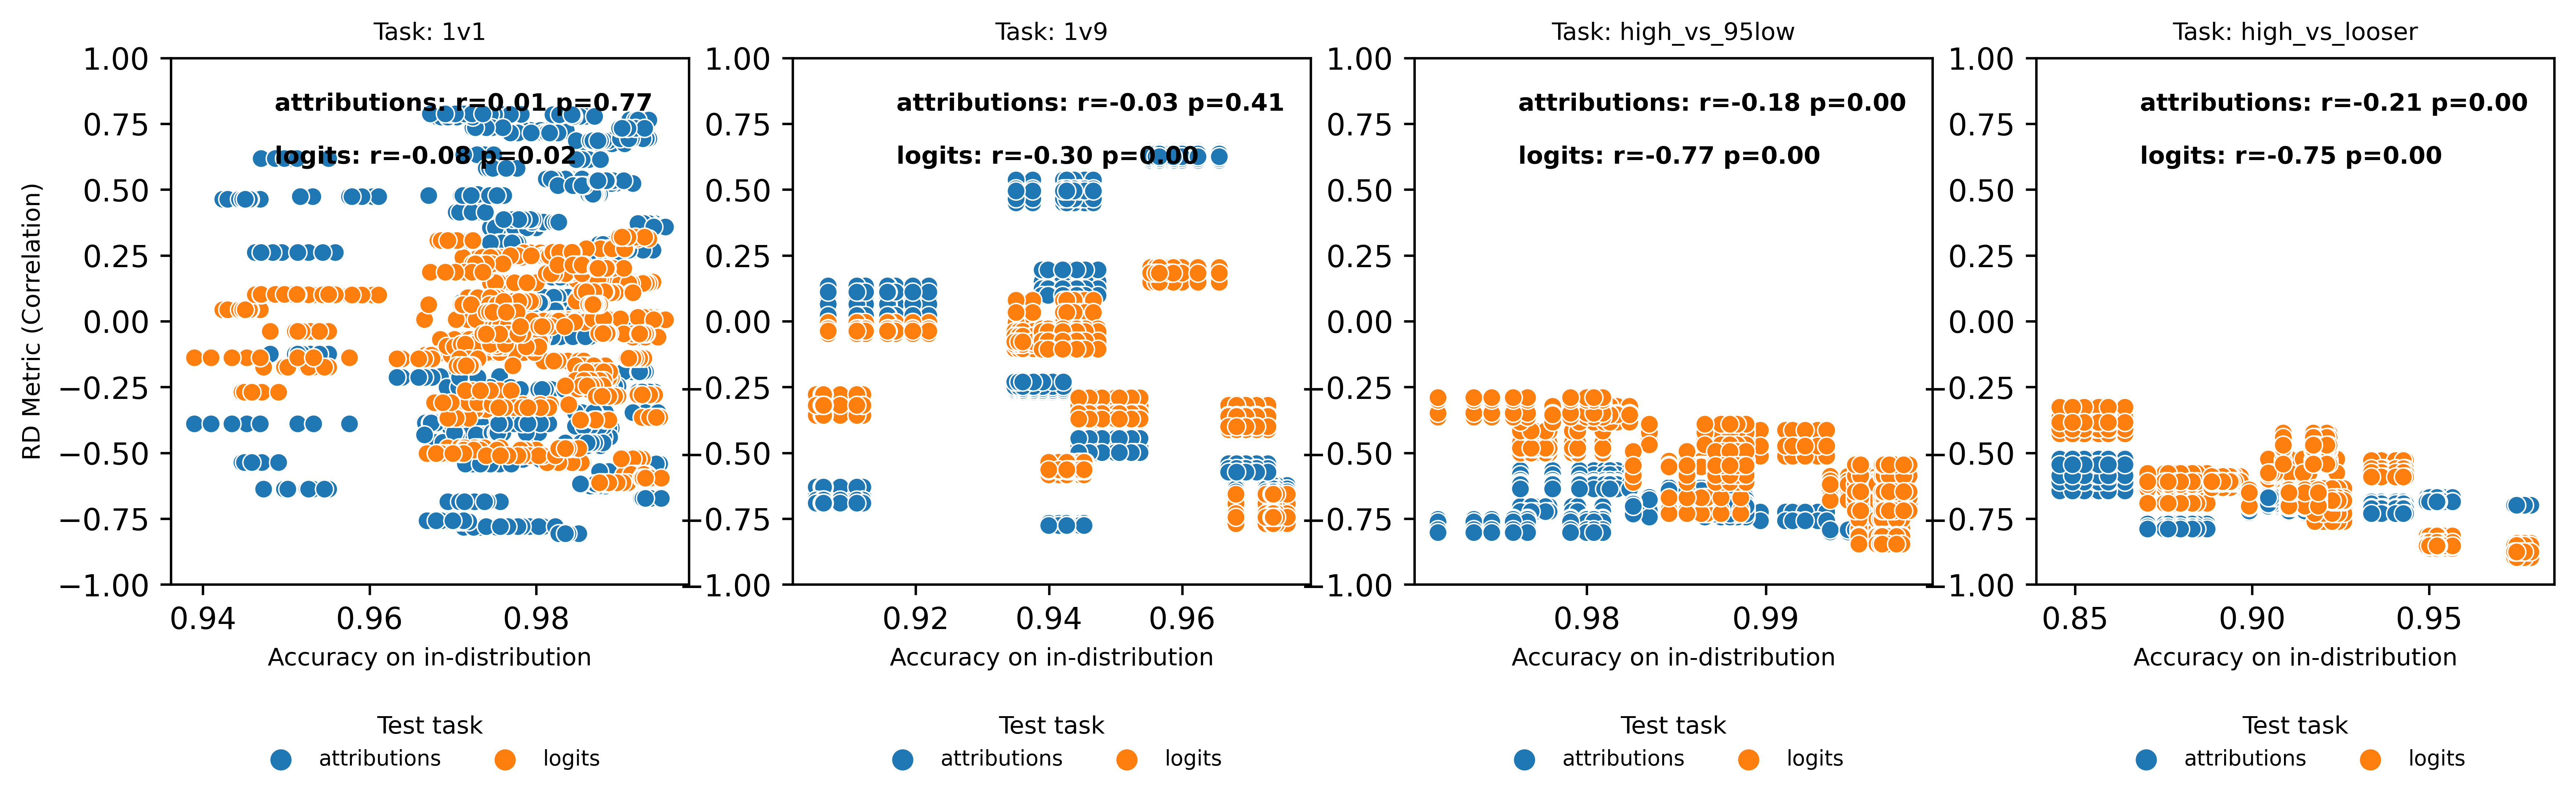

In [9]:
## CODE from 25_Section_1

from scipy.stats import pearsonr

cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4.5 * 3.14, 3.14), dpi=600)

# task_order = visualisations.PlotParams.order_tasks_clean.copy()
# task_order.remove("vs 1")
task_order = ["1v1", "1v9", "high_vs_95low", "high_vs_looser"]

for i, task_i in enumerate(task_order):
    # row = 0
    col = i % 4
    ax = axs[col]
    df_i = df_rd.query("task_type == @task_i") # .loc[~df_rd["is_indistribution"]]
    sns.scatterplot(
        data=df_i,
        x="acc",
        y="rd_metric",
        hue="rd_type",
        # pallette=cmap,
        ax=ax,
    )

    ax.set_title(f"Task: {task_i}", fontsize=8)
    ax.set_xlabel("Accuracy on in-distribution", fontsize=8)
    if col == 0:
        ax.set_ylabel("RD Metric (Correlation)", fontsize=8)
    else:
        ax.set_ylabel(None)
    # ax.set_xlim(0.87, 1.0)
    ax.set_ylim(-1.0, 1.0)

    # Legend location under the plot
    ax.legend(
        bbox_to_anchor=(0.5, -0.3),
        loc="center",
        borderaxespad=0.0,
        fontsize=7,
        title="Test task",
        title_fontsize=8,
        ncol=10,
        frameon=False,
    )

    # Add correlation numbers in the plots
    # 2 numbers per plot, per test_task, 
    # with color corresponding to the plot hue
    for j, rd_type in enumerate(df_i["rd_type"].unique()):
        df_i_tt = df_i.query("rd_type == @rd_type")
        r, pval = pearsonr(df_i_tt["acc"], df_i_tt["rd_metric"])
        ax.text(
            0.2,
            0.9 - 0.1 * j,
            f"{rd_type}: r={r:.2f} p={pval:.2f}",
            fontsize=8,
            fontweight="bold",
            transform=ax.transAxes,
        )

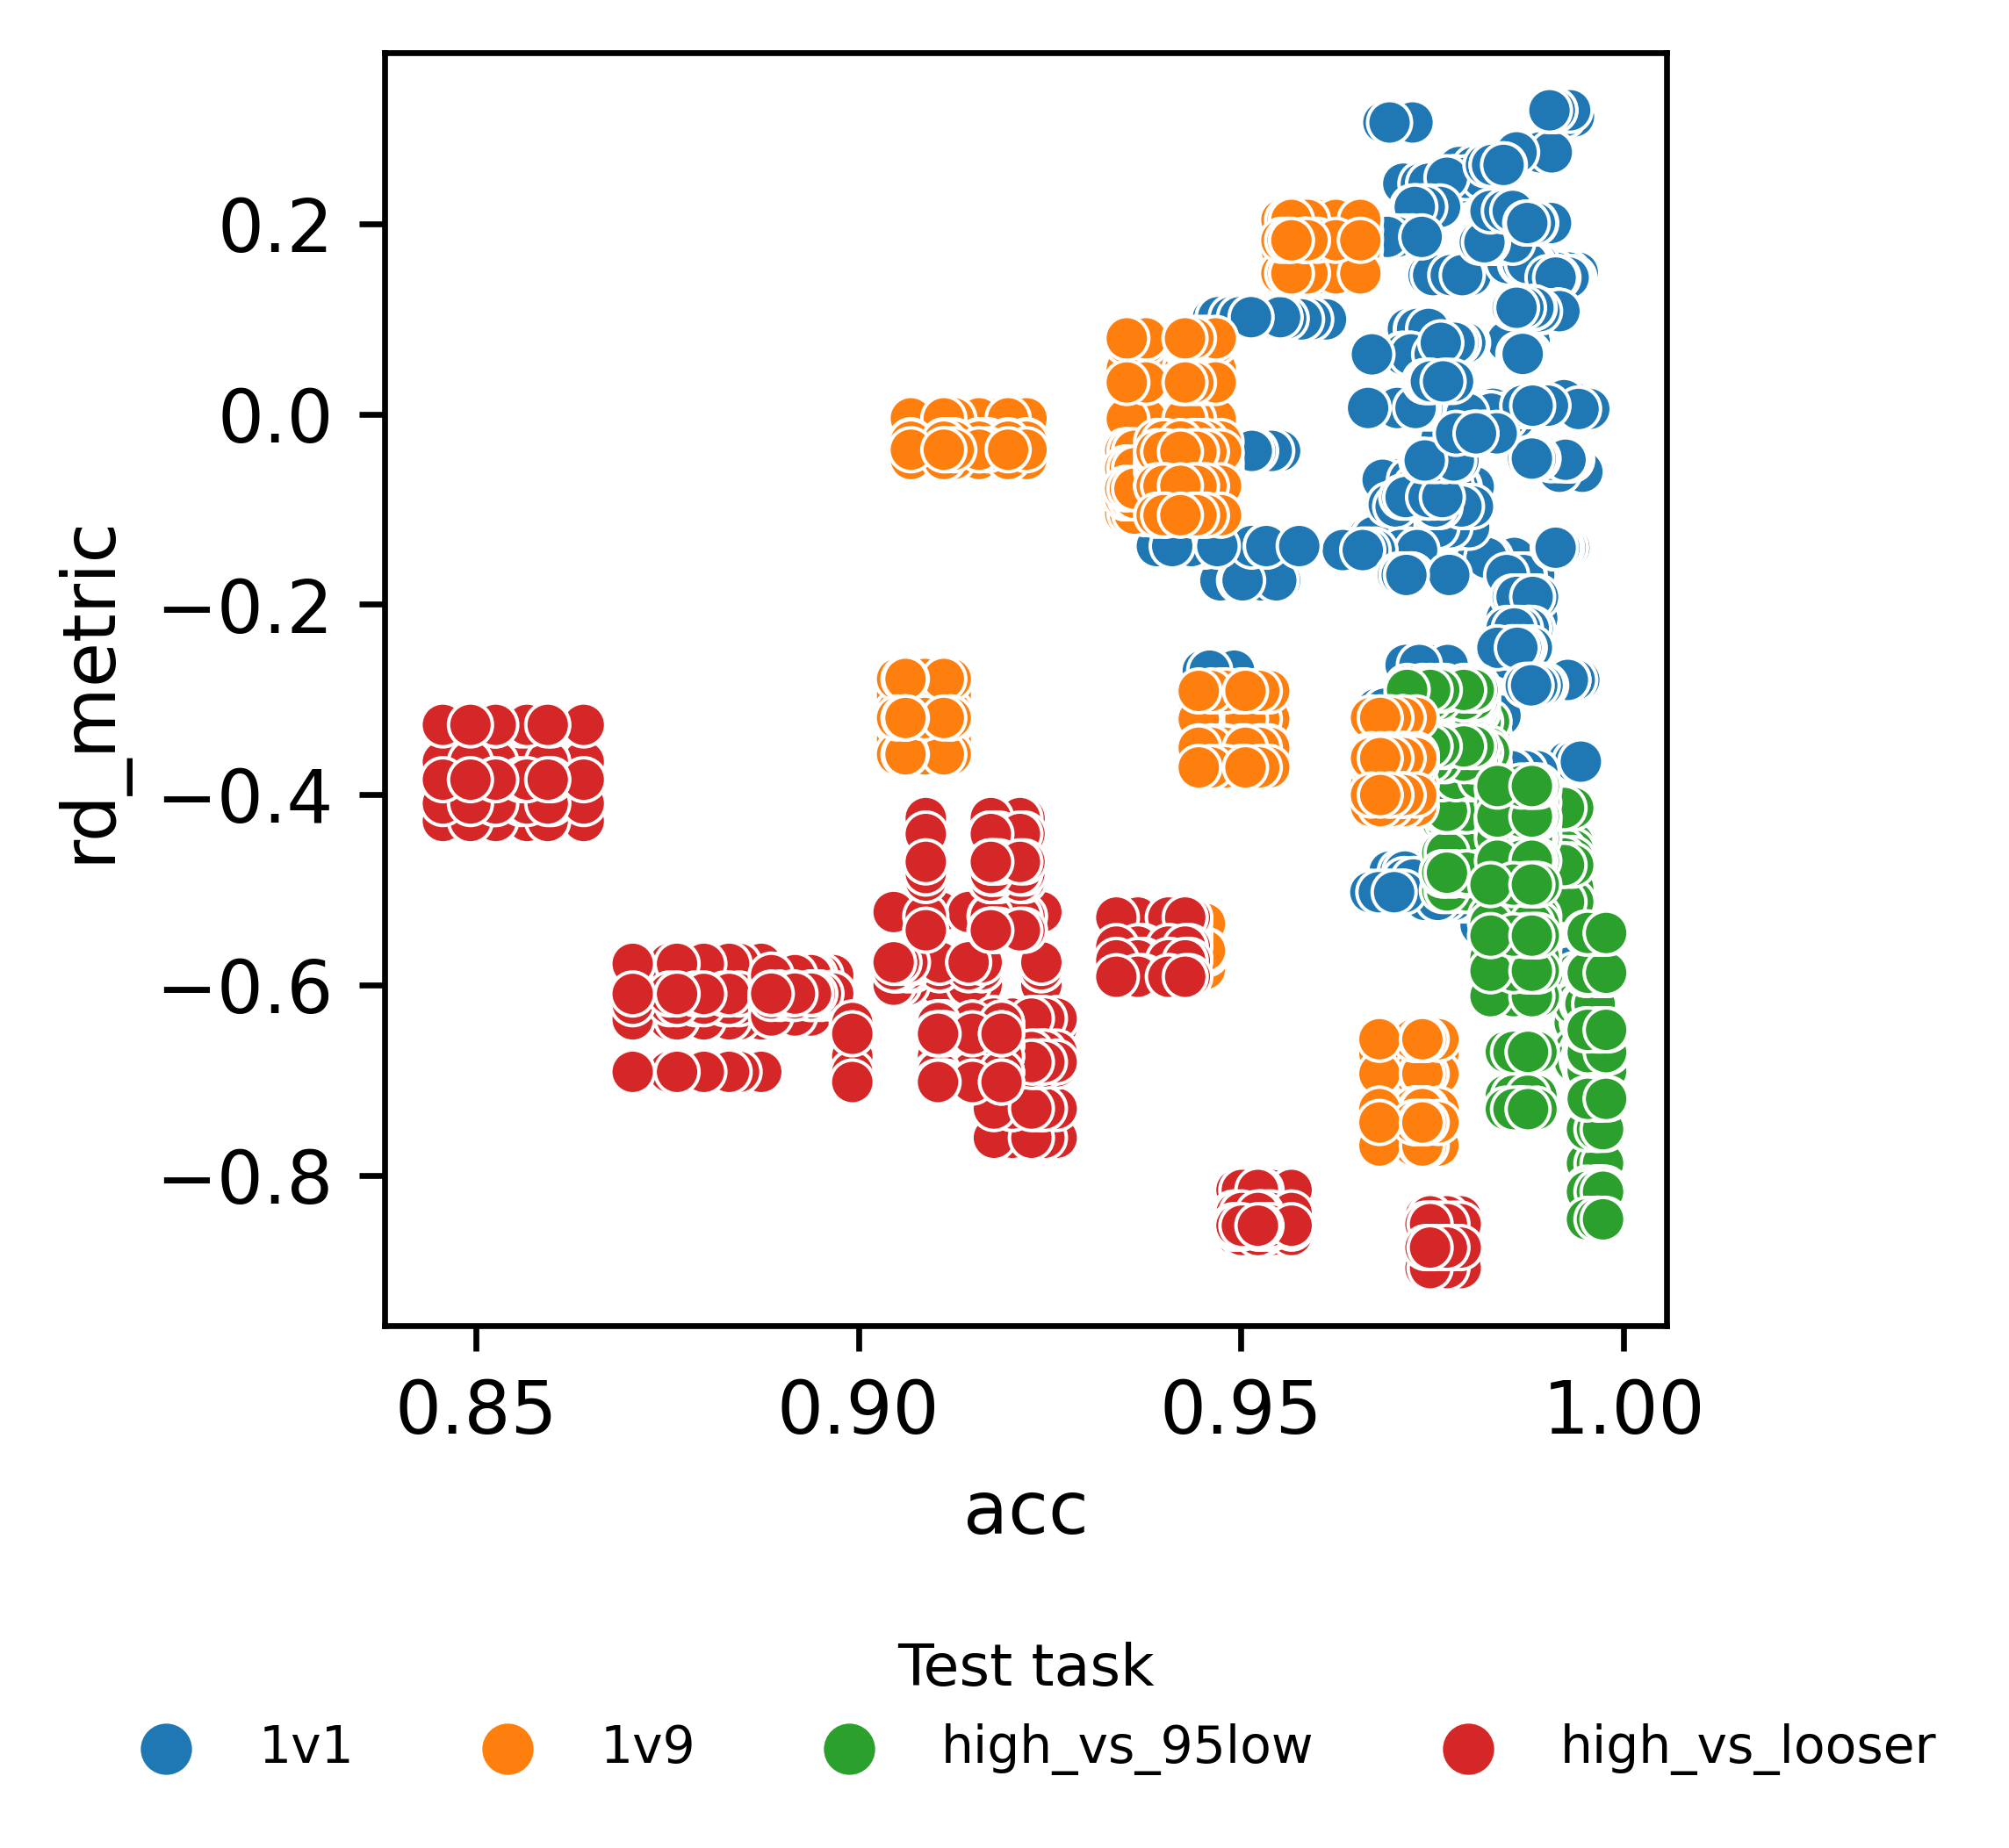

In [10]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(1*3.14, 3.14), dpi=600)

sns.scatterplot(
    data=df_rd.query("rd_type == 'logits'"),
    x="acc",
    y="rd_metric",
    hue="task_type",
    ax=ax,
)
ax.legend(
        bbox_to_anchor=(0.5, -0.3),
        loc="center",
        borderaxespad=0.0,
        fontsize=7,
        title="Test task",
        title_fontsize=8,
        ncol=10,
        frameon=False,
    )

In [11]:
df_rd.groupby(["rd_type", "task_type"])[["acc", "rd_metric"]].median().sort_values("acc").sort_values("rd_type")

acc  rd_metric
rd_type      task_type                          
attributions high_vs_looser  0.917350  -0.693370
             1v9             0.944422  -0.355220
             1v1             0.981200  -0.006491
             high_vs_95low   0.988000  -0.711538
logits       high_vs_looser  0.917350  -0.615479
             1v9             0.944422  -0.192282
             1v1             0.981200  -0.047297
             high_vs_95low   0.988000  -0.506698

RD ~ OOD

In [12]:
df_ood.head()

task_1                             task_2  \
0    ONE_VS_NINE__3VRL__auto__0__42     ONE_VS_NINE__3VRL__auto__0__42   
1    ONE_VS_NINE__3VRL__auto__0__42   HIGH_VS_95LOW__3VRL__auto__0__42   
2    ONE_VS_NINE__3VRL__auto__0__42  HIGH_VS_LOOSER__3VRL__auto__0__42   
3  HIGH_VS_95LOW__3VRL__auto__0__42     ONE_VS_NINE__3VRL__auto__0__42   
4  HIGH_VS_95LOW__3VRL__auto__0__42   HIGH_VS_95LOW__3VRL__auto__0__42   

        acc  recall  precision        f1 ag_1_pos ag_2_pos ag_1_neg ag_2_neg  \
0  0.972986   0.975   0.971116  0.973054     3VRL     3VRL     auto     auto   
1  0.987000   0.975   0.998975  0.986842     3VRL     3VRL     auto     auto   
2  0.882900   0.975   0.823341  0.892775     3VRL     3VRL     auto     auto   
3  0.912356   0.998   0.852117  0.919307     3VRL     3VRL     auto     auto   
4  0.996600   0.998   0.995213  0.996605     3VRL     3VRL     auto     auto   

   seed_1  seed_2  split_1  split_2    ag    task_1_type     task_2_type  
0       0       0       42       42  3VRL            1v9             1v9  
1       0       0       42       42  3VRL            1v9   high_vs_95low  
2       0       0       42       42  3VRL            1v9  high_vs_looser  
3       0       0       42       42  3VRL  high_vs_95low             1v9  
4       0       0       42       42  3VRL  high_vs_95low   high_vs_95low

In [13]:
df_rd_logits = pd.read_csv(
    "../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations_final.tsv",
)
df_rd_logits["rd_type"] = "logits"
df_rd_logits["rd_metric"] = df_rd_logits["r_pos"]


df_rd_attr = pd.read_csv(
    "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions.tsv",
    sep='\t',
)
df_rd_attr["rd_type"] = "attributions"
df_rd_attr["rd_metric"] = df_rd_attr["mean_pos_total"]


df_rd_attr_m = pd.merge(
    df_rd_attr,
    df_ood,
    left_on=["task_type", "ag_pos", "ag_neg"],
    right_on=["task_1_type", "ag_1_pos", "ag_1_neg"],
    how="inner",
)

df_rd_logits_m = pd.merge(
    df_rd_logits,
    df_ood,
    left_on=["task_type", "ag_pos", "ag_neg"],
    right_on=["task_1_type", "ag_1_pos", "ag_1_neg"],
    how="inner",
)
# df_rd_attr_m.head()

df_rd = pd.concat([df_rd_attr_m, df_rd_logits_m], axis=0)
df_rd.head()

task_type ag_pos ag_neg  seed_id  split_id      mean       std  mean_pos  \
0       1v9   3VRL   auto        0        42 -0.675516  0.126424 -0.675516   
1       1v9   3VRL   auto        0        42 -0.675516  0.126424 -0.675516   
2       1v9   3VRL   auto        0        42 -0.675516  0.126424 -0.675516   
3       1v9   3VRL   auto        0        42 -0.675516  0.126424 -0.675516   
4       1v9   3VRL   auto        0        42 -0.675516  0.126424 -0.675516   

    std_pos  mean_neg  ...  Energy_std  logits_pos_mean  logits_pos_std  \
0  0.126424       NaN  ...         NaN              NaN             NaN   
1  0.126424       NaN  ...         NaN              NaN             NaN   
2  0.126424       NaN  ...         NaN              NaN             NaN   
3  0.126424       NaN  ...         NaN              NaN             NaN   
4  0.126424       NaN  ...         NaN              NaN             NaN   

   Energy_pos_mean  Energy_pos_std  logits_neg_mean  logits_neg_std  \
0              NaN             NaN              NaN             NaN   
1              NaN             NaN              NaN             NaN   
2              NaN             NaN              NaN             NaN   
3              NaN             NaN              NaN             NaN   
4              NaN             NaN              NaN             NaN   

   Energy_neg_mean  Energy_neg_std  corr_type  
0              NaN             NaN        NaN  
1              NaN             NaN        NaN  
2              NaN             NaN        NaN  
3              NaN             NaN        NaN  
4              NaN             NaN        NaN  

[5 rows x 66 columns]

In [15]:
assert all(df_rd["ag_1_pos"] == df_rd["ag_2_pos"])

# Remove "OOD" with task_1 type == task_2 type
df_rd = df_rd.loc[(df_rd["task_1_type"] != df_rd["task_2_type"])].copy()


col_sel = [
    "task_1_type",
    "ag_1_pos",
    "ag_1_neg",
    "seed_1",
    "split_1",
    "task_2_type",
    "ag_2_pos",
    "ag_2_neg",
    "seed_2",
    "split_2",
    "acc",
    "rd_metric",
    "rd_type",
]
df_rd[col_sel]

task_1_type ag_1_pos ag_1_neg  seed_1  split_1     task_2_type  \
1                1v9     3VRL     auto       0       42   high_vs_95low   
2                1v9     3VRL     auto       0       42  high_vs_looser   
4                1v9     3VRL     auto       1       42   high_vs_95low   
5                1v9     3VRL     auto       1       42  high_vs_looser   
7                1v9     3VRL     auto       2       42   high_vs_95low   
...              ...      ...      ...     ...      ...             ...   
7282  high_vs_looser     1OB1     auto       0        2   high_vs_95low   
7284  high_vs_looser     1OB1     auto       0        3             1v9   
7285  high_vs_looser     1OB1     auto       0        3   high_vs_95low   
7287  high_vs_looser     1OB1     auto       0        4             1v9   
7288  high_vs_looser     1OB1     auto       0        4   high_vs_95low   

     ag_2_pos ag_2_neg  seed_2  split_2       acc  rd_metric       rd_type  
1        3VRL     auto       0       42  0.987000  -0.643708  attributions  
2        3VRL     auto       0       42  0.882900  -0.643708  attributions  
4        3VRL     auto       1       42  0.988400  -0.643708  attributions  
5        3VRL     auto       1       42  0.869800  -0.643708  attributions  
7        3VRL     auto       2       42  0.989700  -0.643708  attributions  
...       ...      ...     ...      ...       ...        ...           ...  
7282     1OB1     auto       0        2  0.938800  -0.651385        logits  
7284     1OB1     auto       0        3  0.914557  -0.651385        logits  
7285     1OB1     auto       0        3  0.952900  -0.651385        logits  
7287     1OB1     auto       0        4  0.916558  -0.651385        logits  
7288     1OB1     auto       0        4  0.959200  -0.651385        logits  

[9720 rows x 13 columns]

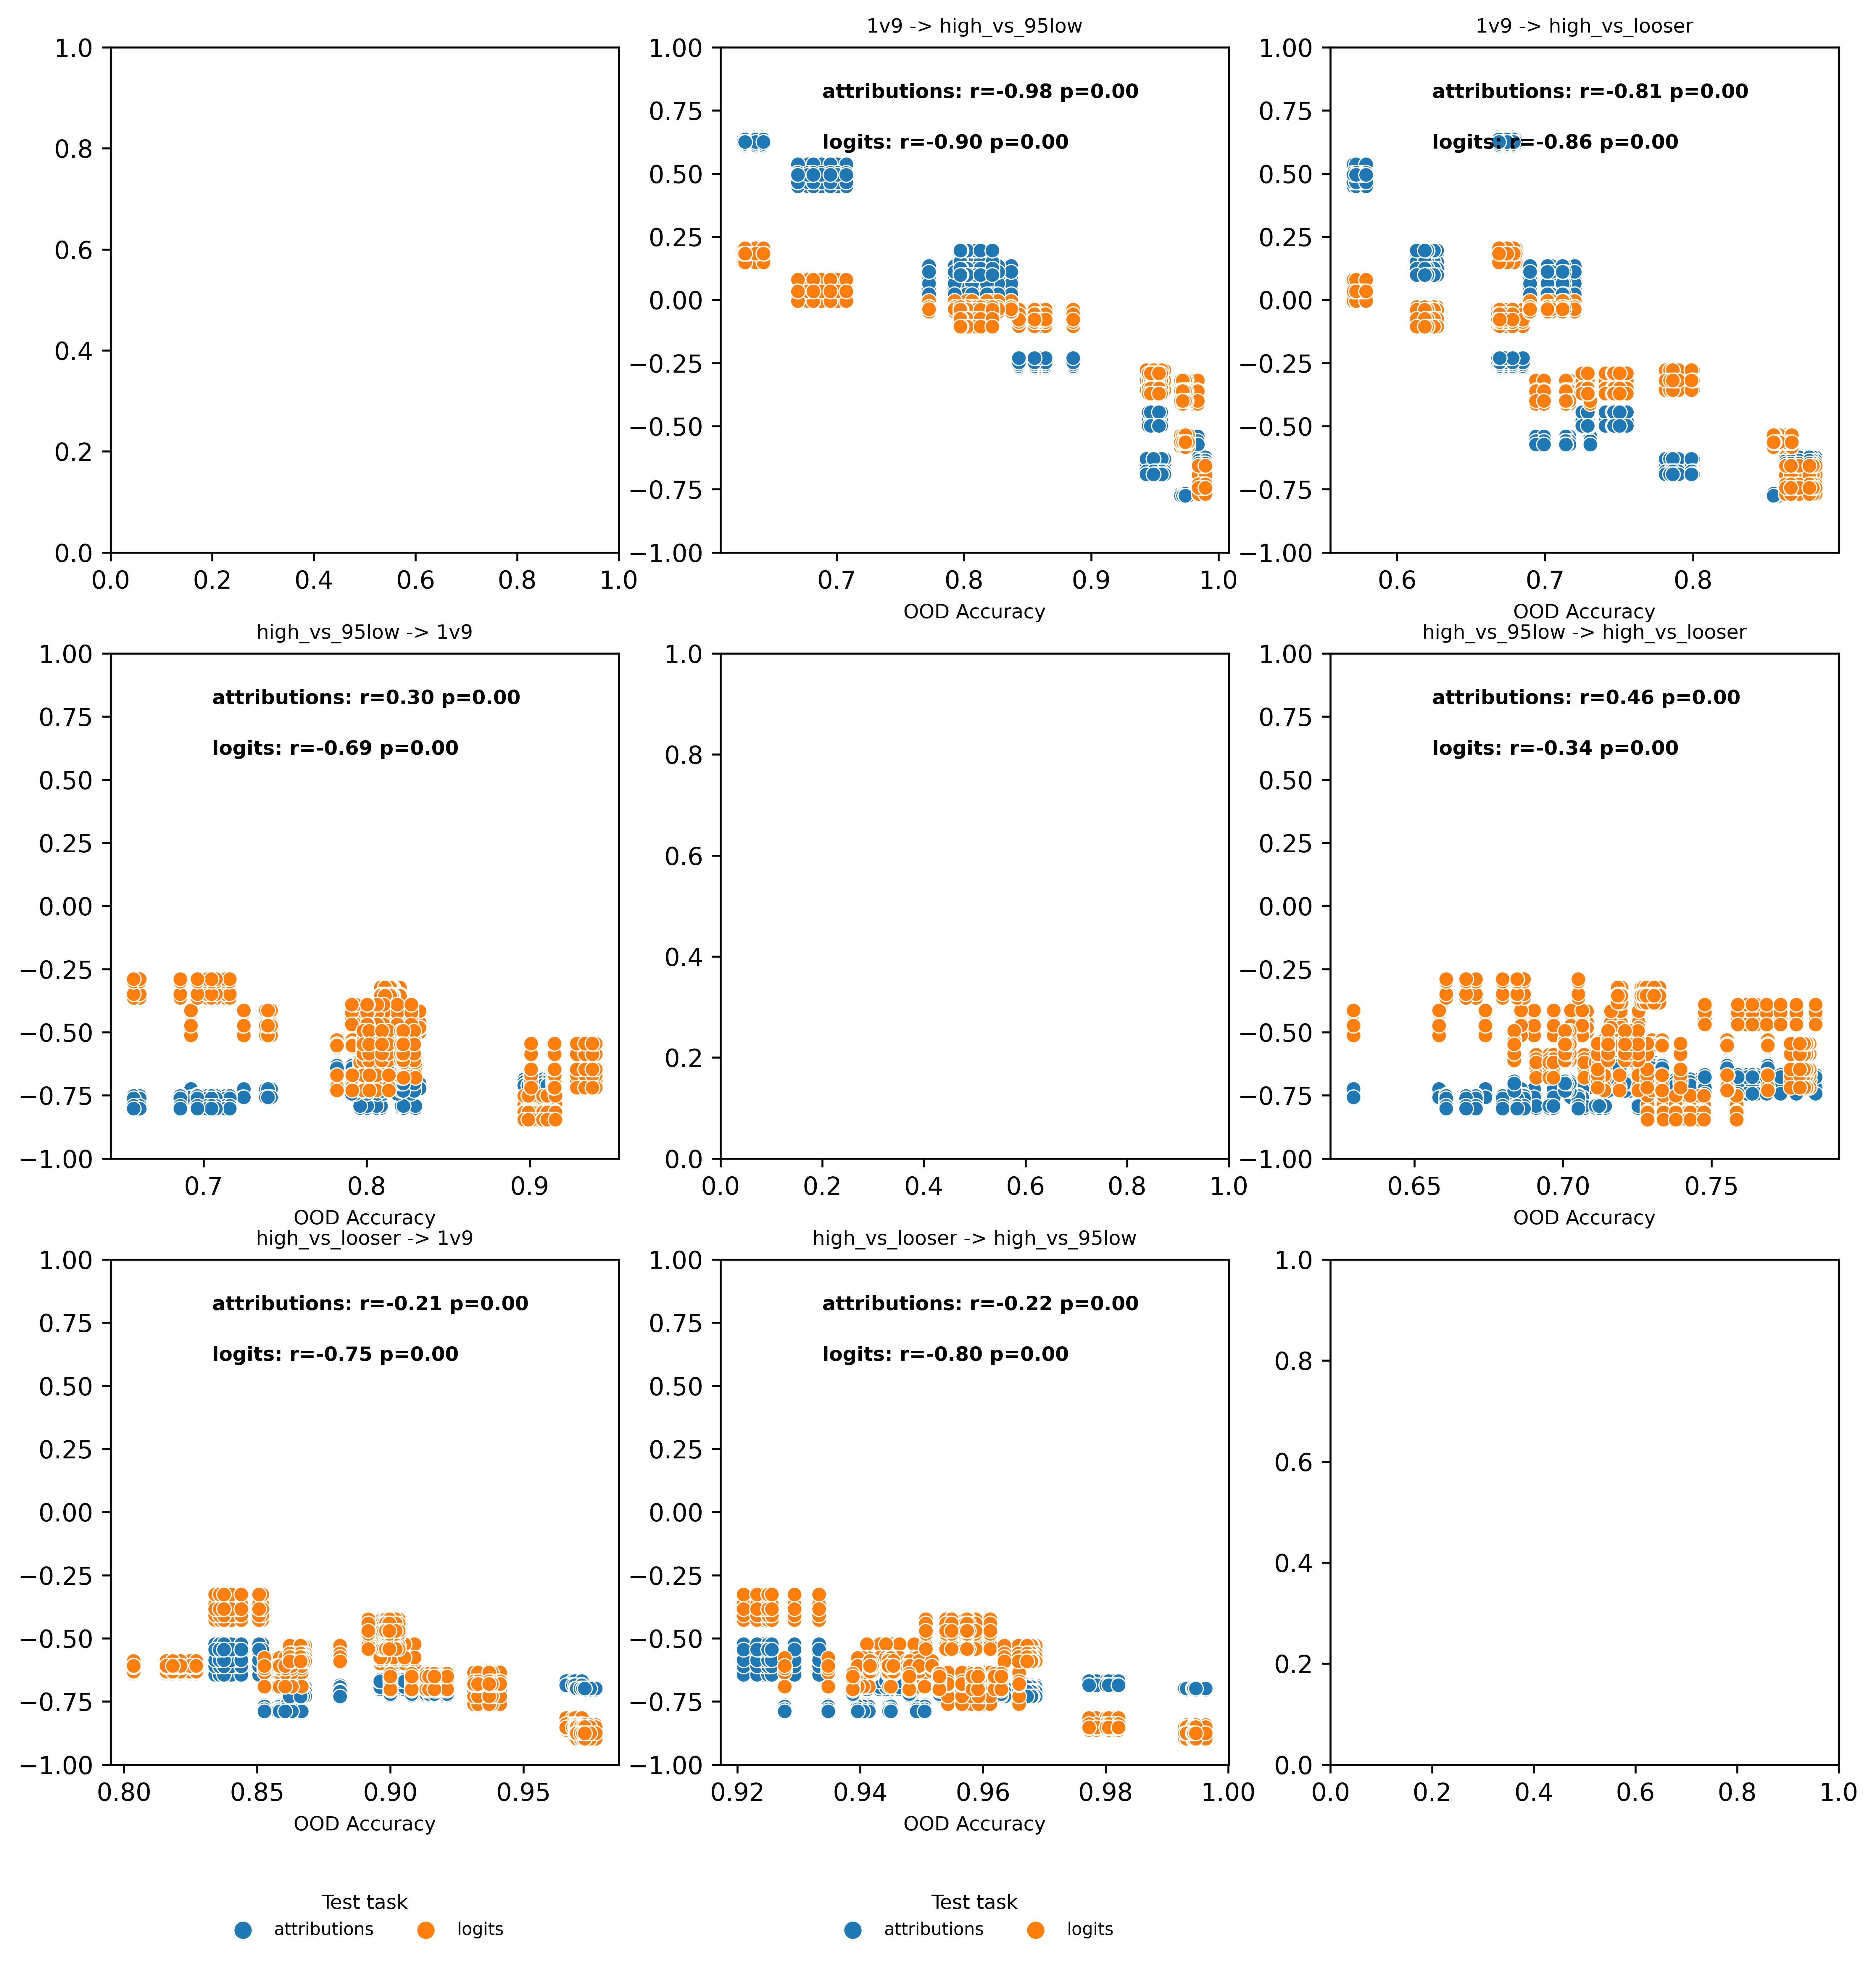

In [22]:
from itertools import permutations


task_types = df_rd["task_1_type"].unique()

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(4*3.14, 4*3.14), dpi=600)

for i in range(0, len(task_types)):
    for j in range(0, len(task_types)):
        if i == j:
            continue
        task_1 = task_types[i]
        task_2 = task_types[j]
        df_rd_i = df_rd.query("task_1_type == @task_1 and task_2_type == @task_2")
        ax = axs[i, j]

        sns.scatterplot(
            data=df_rd_i,
            x="acc",
            y="rd_metric",
            hue="rd_type",
            ax=ax,
        )

        ax.set_title(f"{task_1} -> {task_2}", fontsize=8)
        ax.set_xlabel("OOD Accuracy", fontsize=8)
        if col == 0:
            ax.set_ylabel("RD Metric (Correlation)", fontsize=8)
        else:
            ax.set_ylabel(None)
        # ax.set_xlim(0.87, 1.0)
        ax.set_ylim(-1.0, 1.0)

        # Legend location under the plot
        ax.legend(
            bbox_to_anchor=(0.5, -0.3),
            loc="center",
            borderaxespad=0.0,
            fontsize=7,
            title="Test task",
            title_fontsize=8,
            ncol=10,
            frameon=False,
        )

        # Add correlation numbers in the plots
        # 2 numbers per plot, per test_task, 
        # with color corresponding to the plot hue
        for j, rd_type in enumerate(df_i["rd_type"].unique()):
            df_i_tt = df_rd_i.query("rd_type == @rd_type")
            r, pval = pearsonr(df_i_tt["acc"], df_i_tt["rd_metric"])
            ax.text(
                0.2,
                0.9 - 0.1 * j,
                f"{rd_type}: r={r:.2f} p={pval:.2f}",
                fontsize=8,
                fontweight="bold",
                transform=ax.transAxes,
            )